In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix,f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, balanced_accuracy_score, fbeta_score, recall_score, precision_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2 , SelectPercentile , f_classif
from sklearn.metrics import accuracy_score
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from utils_fraud import fit_score,variance, correlation, randomForestSelector, Anova, gridSearch,randomForestSelectorRanges
from cgans import cGAN
from imblearn.over_sampling import SMOTE

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import average_precision_score, confusion_matrix


Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## create test  data

In [5]:
data_class_fraud=data.loc[data['Class'] == 1]
data_class_fraud.shape

(492, 31)

In [6]:
zz=data_class_fraud.iloc[:100,:]
zz.shape

(100, 31)

In [7]:
data_nonfraud = data.loc[data['Class'] == 0]

In [8]:
nn=data_nonfraud.sample(frac =.01)
nn.shape

(2843, 31)

In [9]:
test_origin=pd.concat([zz, nn], axis=0, sort=False)
test_origin.shape

(2943, 31)

In [10]:
# we shuffle our test data
test_origin=test_origin.sample(frac=1)
test_origin.shape

(2943, 31)

In [11]:
x_test_origin=test_origin.drop(['Class'],axis=1)
x_test_origin.shape

(2943, 30)

In [12]:
y_test_origin= test_origin['Class']
y_test_origin.shape

(2943,)

In [13]:
data_train=data.drop([test_origin.index[0]],axis=0)
data_train.shape

(284806, 31)

## we normalize our test data and train data

In [14]:
rob_scaler = RobustScaler()
scaled_amount = rob_scaler.fit_transform(x_test_origin['Amount'].values.reshape(-1,1))
scaled_time = rob_scaler.fit_transform(x_test_origin['Time'].values.reshape(-1,1))
x_test_origin.insert(0, 'scaled_amount', scaled_amount)
x_test_origin.insert(1, 'scaled_time', scaled_time)
x_test_origin.drop(['Time','Amount'], axis=1, inplace=True)
x_test_origin.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
148789,-0.220452,0.096130,-1.534058,0.532045,1.511501,-0.461526,1.615022,-1.269228,0.782189,-0.574667,...,-0.130487,-0.122873,-0.569764,-0.942380,-0.548829,-0.007667,0.481685,0.253688,-0.107589,-0.140720
139828,-0.159041,0.018099,-1.097397,0.069442,2.790521,1.224827,0.100116,-0.345517,-0.384136,0.238025,...,0.688420,0.253821,0.056220,0.137825,-0.139211,0.398934,0.282403,-0.275857,0.105729,0.106821
97184,-0.282952,-0.179302,1.196142,0.240170,0.630515,0.643610,-0.419281,-0.701367,0.014858,-0.108586,...,-0.602604,-0.113892,-0.204660,-0.539284,0.202756,0.404986,0.113806,0.102906,-0.009572,0.019552
10071,-0.254357,-0.760001,-0.780471,1.908769,-0.559762,0.918872,0.243109,-0.218734,0.058477,0.775375,...,0.188692,-0.043997,0.105470,0.615375,0.106826,-0.335056,-0.666344,-0.415076,0.286900,0.142378
62956,0.394063,-0.357702,-1.776959,1.756367,0.466962,0.684352,-0.673629,-0.623018,0.407954,0.415924,...,0.546270,0.168615,0.092639,0.468529,-0.000094,0.510223,-0.118419,-0.346327,0.372998,0.355829


In [15]:
rob_scaler = RobustScaler()
scaled_amount = rob_scaler.fit_transform(data_train['Amount'].values.reshape(-1,1))
scaled_time = rob_scaler.fit_transform(data_train['Time'].values.reshape(-1,1))
data_train.insert(0, 'scaled_amount', scaled_amount)
data_train.insert(1, 'scaled_time', scaled_time)
data_train.drop(['Time','Amount'], axis=1, inplace=True)
data_train.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783212,-0.994972,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269815,-0.994972,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983547,-0.994960,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418242,-0.994960,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670556,-0.994948,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


<h1>Random under sampling</h1>
<p>We will use the random undersampler function to balance our data</p>

In [16]:
X_train_origin = data_train.drop('Class', axis=1)
Y_train_origin = data_train['Class']

In [17]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority',random_state=4)
# fit and apply the transform
X_RF, Y_RF = undersample.fit_resample(X_train_origin, Y_train_origin)
print(Y_RF.count())
rus_df = pd.concat([X_RF, Y_RF],axis=1, sort=False)
rus_df

984


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.693751,0.716728,1.974725,0.029901,-2.051231,0.421964,0.487407,-1.089438,0.398110,-0.409847,...,-0.000104,0.199566,0.635917,-0.174414,-0.695667,0.344301,-0.070238,-0.011543,-0.024736,0
1,-0.251371,-0.857013,-0.505372,1.279945,0.807395,0.486464,-0.239971,-0.950016,0.359865,-0.255986,...,0.068281,-0.092533,-0.042785,-0.083584,0.432027,-0.412412,1.123740,-0.732085,-0.244393,0
2,0.015370,-0.870441,1.231712,-0.089101,0.655684,0.406777,-0.696112,-0.701142,-0.252769,-0.229943,...,-0.081947,-0.252820,-0.260043,-0.064598,0.445576,0.421992,1.070156,-0.095377,-0.002946,0
3,1.311769,0.018016,1.072747,-0.285097,-1.247048,0.025080,2.040874,3.407150,-0.322519,0.782215,...,0.213113,-0.039386,-0.490331,-0.153819,0.991068,0.661190,-0.435313,0.003800,0.038316,0
4,-0.271212,0.694794,-0.098760,0.417296,0.961061,-0.663476,0.187826,0.151540,-0.014324,0.005897,...,0.201473,0.094410,0.878668,0.083660,0.291908,-1.643540,0.250842,0.321098,0.003652,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,5.141999,0.992140,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,...,1.252967,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,1
980,-0.296783,0.994549,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,...,0.226138,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,1
981,0.780941,0.994596,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,...,0.247968,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,1
982,3.115939,1.001821,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,...,0.306271,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,1


## Feature selection

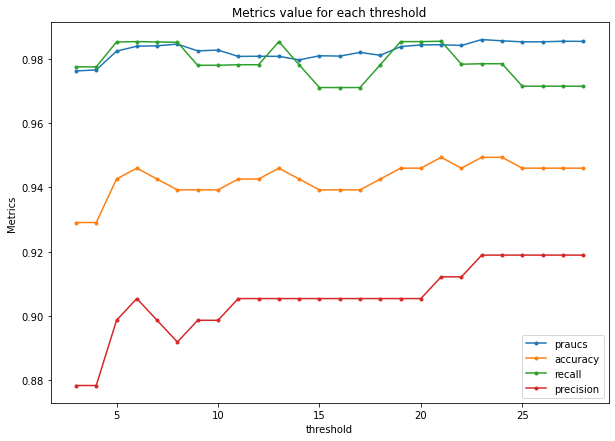

In [18]:
#use the randomForestSelector function to select the best features
randomForestFeatures = randomForestSelectorRanges(X_RF, Y_RF, 3,29)

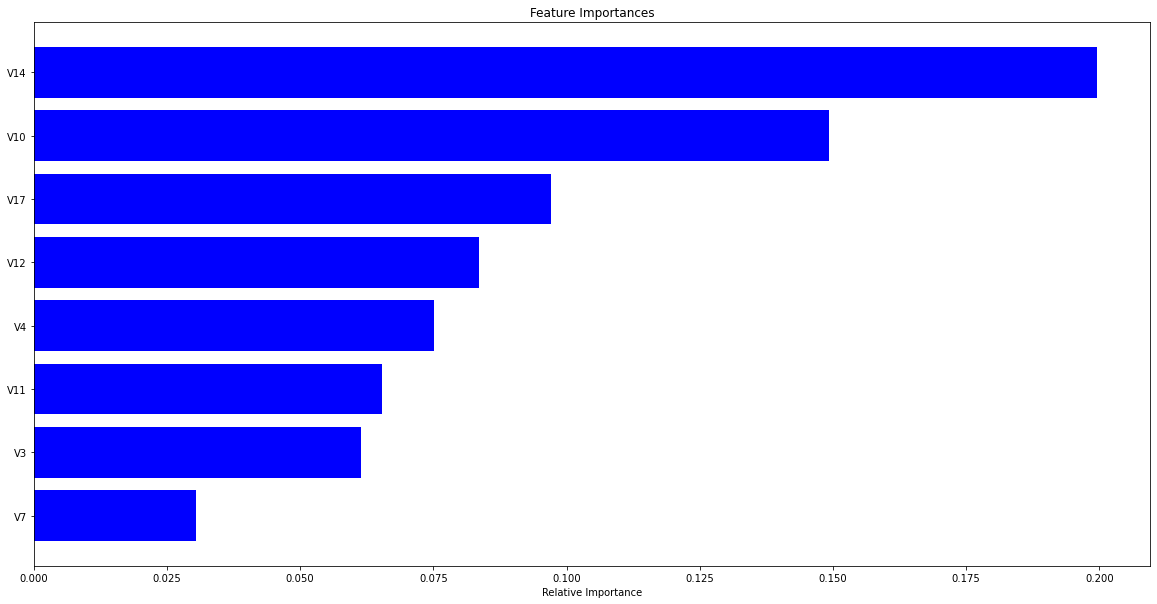

,V7,V3,V11,V4,V12,V17,V10,V14
0,0.398110,-2.051231,-0.846258,0.421964,0.213204,0.107143,-0.523239,-0.894861
1,0.359865,0.807395,0.731136,0.486464,-2.454813,1.181220,-0.167139,1.755408
2,-0.252769,0.655684,0.285983,0.406777,-1.902472,0.910143,-0.746753,1.161687
3,-0.322519,-1.247048,-0.135573,0.025080,0.062923,-0.973195,0.004702,0.493438
4,-0.014324,0.961061,-1.191515,-0.663476,-1.435937,-0.099095,-0.177693,-2.040388
...,...,...,...,...,...,...,...,...
979,-0.882850,-4.518331,2.115795,1.749293,-5.417424,-4.570529,-5.587794,-6.665177
980,-1.413170,-5.004247,2.858466,1.411850,-3.096915,-3.267116,-3.232153,-5.210141
981,-2.234739,-2.213700,1.794969,0.468308,-2.775022,-5.035326,-3.463891,-4.057162
982,-2.208002,-5.399730,1.933520,1.817092,-5.030465,-4.614717,-5.245984,-6.416628


In [19]:
randomForestFeatures = randomForestSelector(X_RF, Y_RF, 8)
data_featured = X_RF.loc[:, randomForestFeatures]
data_featured

In [20]:
models = [
          {
            "Model":LogisticRegression(random_state=0),
            "params" : {"C":[0.001,0.01,0.1,1,10,100], "penalty":["l1","l2"]}
          },
          {
            "Model":xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,random_state=0),
            "params" : {'max_depth': range (2, 10, 1),'n_estimators': range(60, 220, 40), 
                        'learning_rate': [0.1, 0.01, 0.05]}
          },
          {
            "Model":RandomForestClassifier(random_state=0),
            "params" : {'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40], 
                         'min_samples_split': [2, 5, 10], 'n_estimators': [100, 200, 500]}        
          }
              ]

#  score without feauture selection, only RUS

We train our model on data_featured as X_test and Y_RF as our y_test and we will test it with our test data x_test_origin and y_test_origin

In [21]:
Counter(Y_RF)

Counter({0: 492, 1: 492})

In [22]:
grid_models =gridSearch(X_RF,Y_RF, models)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    4.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.8min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.6min finished


Model name :  LogisticRegression(random_state=0)
Best Parameters {'C': 100, 'penalty': 'l2'}
AUC-score : [0.9969152303904327]
Precision-Recall-auc:  [0.9696270833932917]
Balanced accuracy score [0.9748751319029194]
Recall : [0.98]
Precision : [0.532608695652174]
F1_score [0.6901408450704226]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2843
           1       0.53      0.98      0.69       100

    accuracy                           0.97      2943
   macro avg       0.77      0.97      0.84      2943
weighted avg       0.98      0.97      0.97      2943

[[2757   86]
 [   2   98]]


roc_curve:


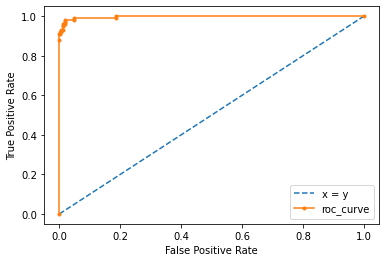



prauc_curve:


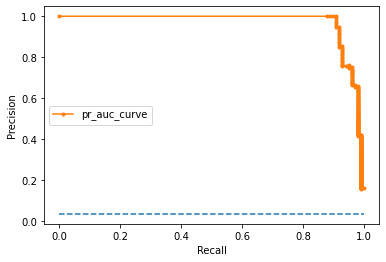

********
Model name :  XGBClassifier(nthread=4)
Best Parameters {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 140}
AUC-score : [0.9995005276116777]
Precision-Recall-auc:  [0.9884948170919773]
Balanced accuracy score [0.9841716496658459]
Recall : [1.0]
Precision : [0.5263157894736842]
F1_score [0.6896551724137931]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2843
           1       0.53      1.00      0.69       100

    accuracy                           0.97      2943
   macro avg       0.76      0.98      0.84      2943
weighted avg       0.98      0.97      0.97      2943

[[2753   90]
 [   0  100]]


roc_curve:


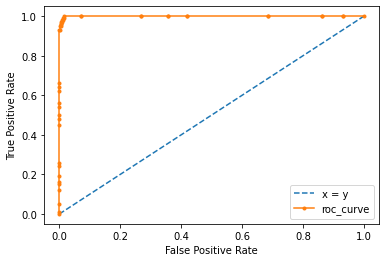



prauc_curve:


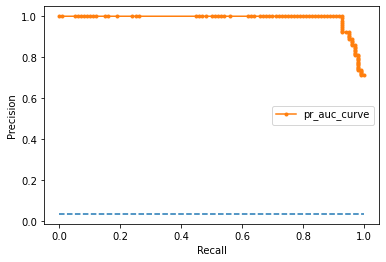

********
Model name :  RandomForestClassifier(random_state=0)
Best Parameters {'bootstrap': False, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
AUC-score : [0.9999771368272952]
Precision-Recall-auc:  [0.999389245014245]
Balanced accuracy score [0.9855786141399929]
Recall : [1.0]
Precision : [0.5494505494505495]
F1_score [0.7092198581560284]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      2843
           1       0.55      1.00      0.71       100

    accuracy                           0.97      2943
   macro avg       0.77      0.99      0.85      2943
weighted avg       0.98      0.97      0.98      2943

[[2761   82]
 [   0  100]]


roc_curve:


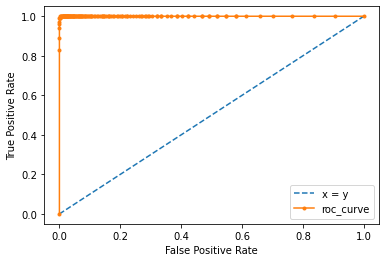



prauc_curve:


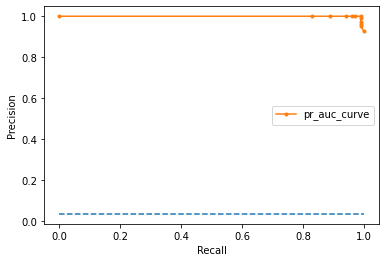

********
GridSearchCV(cv=5, estimator=XGBClassifier(nthread=4), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             scoring='recall', verbose=1)


In [23]:
for i in range(len(models)):
  print("Model name : ", models[i]["Model"])
  fit_score(grid_models[i], x_test_origin,y_test_origin)
  print("********")
print(grid_models[1])

# We apply unsupervised model for outliers detection

## We choose 1% of data for computational reasons

In [24]:
data_frac = data_train.sample(frac =.1)
data_frac.shape

(28481, 31)

In [25]:
columns = data_frac.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X_outliers = data_frac[columns]
Y_outliers = data_frac[target]
X_outliers = state.uniform(low=0, high=1, size=(X_outliers.shape[0], X_outliers.shape[1]))
# Print the shapes of X & Y
print(X_outliers.shape)
print(Y_outliers.shape)

(28481, 30)
(28481,)


### we compute the outlier fraction for the contamination hyperparam

In [26]:
Fraud = data_frac[data_frac['Class']==1]

Valid = data_frac[data_frac['Class']==0]

outlier_fraction = (len(Fraud)/float(len(Valid)))*100
print('number of fraud in 1% of dataset :', Fraud.shape)
print('number of valid in 1% of dataset :', Valid.shape)
print('outlier_fraction:' , outlier_fraction,'% of the dataset')

number of fraud in 1% of dataset : (53, 31)
number of valid in 1% of dataset : (28428, 31)
outlier_fraction: 0.1864359082594625 % of the dataset


 ### We choose Isolation Forest  and Support Vector Machine

In [27]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, 
                                       contamination=0.1,random_state=0, verbose=0),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.01, 
                                         max_iter=-1)
   
}

In [28]:
train_valid,test_valid = train_test_split(Valid.drop(['Class'],axis=1) , test_size=0.3, random_state=0)

outliers=Fraud.drop(['Class'],axis=1)

In [29]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Isolation Forest":
        clf.fit(train_valid)
        y_pred_outliers= clf.predict(outliers)
        y_pred_valid= clf.predict(test_valid)
    else:
        clf.fit(train_valid)
        y_pred_outliers= clf.predict(outliers)
        y_pred_valid= clf.predict(test_valid)
    # Run Classification Metrics
    print('******')
    print(clf_name)
    print("Accuracy in Detecting Legit Cases:", list(y_pred_valid).count(1)/y_pred_valid.shape[0])
    print("Accuracy in Detecting Fraud Cases:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

******
Isolation Forest
Accuracy in Detecting Legit Cases: 0.8983468167428772
Accuracy in Detecting Fraud Cases: 0.8867924528301887
******
Support Vector Machine
Accuracy in Detecting Legit Cases: 0.8664556219955446
Accuracy in Detecting Fraud Cases: 0.9245283018867925


# Score with feature selection and RUS

In [30]:
x_train_fs, x_test_fs, y_train_fs, y_test_fs = train_test_split(data_featured, Y_RF, test_size=0.3, stratify=Y_RF, random_state=0)

In [31]:
grid_models =gridSearch(x_train_fs,y_train_fs, models)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.5min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.9min finished


Model name :  LogisticRegression(random_state=0)
Best Parameters {'C': 1, 'penalty': 'l2'}
AUC-score : [0.9968870911009498]
Precision-Recall-auc:  [0.9642254749957953]
Balanced accuracy score [0.9639957791065775]
Recall : [0.96]
Precision : [0.5133689839572193]
F1_score [0.6689895470383276]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2843
           1       0.51      0.96      0.67       100

    accuracy                           0.97      2943
   macro avg       0.76      0.96      0.83      2943
weighted avg       0.98      0.97      0.97      2943

[[2752   91]
 [   4   96]]


roc_curve:


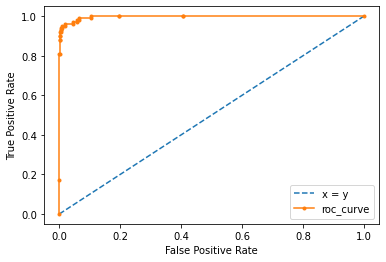



prauc_curve:


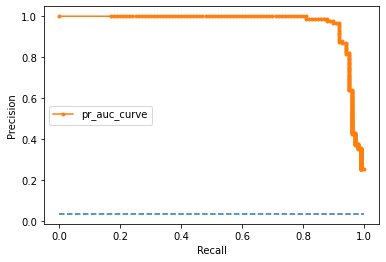


Model name :  XGBClassifier(nthread=4)
Best Parameters {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 60}
AUC-score : [0.995]
Precision-Recall-auc:  [0.9116189186774026]
Balanced accuracy score [0.9683679212099894]
Recall : [0.98]
Precision : [0.4434389140271493]
F1_score [0.6105919003115264]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2843
           1       0.44      0.98      0.61       100

    accuracy                           0.96      2943
   macro avg       0.72      0.97      0.79      2943
weighted avg       0.98      0.96      0.97      2943

[[2720  123]
 [   2   98]]


roc_curve:


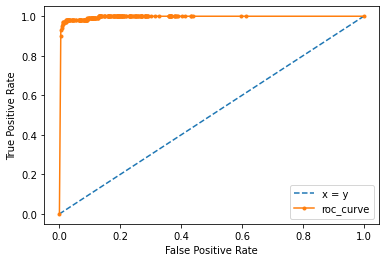



prauc_curve:


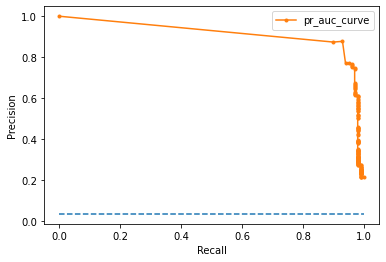


Model name :  RandomForestClassifier(random_state=0)
Best Parameters {'bootstrap': False, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
AUC-score : [0.9948047836792122]
Precision-Recall-auc:  [0.9825419324967501]
Balanced accuracy score [0.9731164263102356]
Recall : [0.98]
Precision : [0.5051546391752577]
F1_score [0.6666666666666666]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2843
           1       0.51      0.98      0.67       100

    accuracy                           0.97      2943
   macro avg       0.75      0.97      0.82      2943
weighted avg       0.98      0.97      0.97      2943

[[2747   96]
 [   2   98]]


roc_curve:


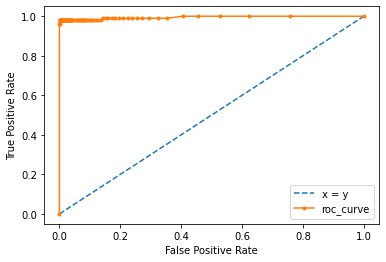



prauc_curve:


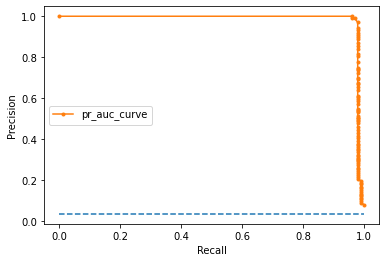

In [32]:
for i in range(len(models)):
  print("Model name : ", models[i]["Model"])
  fit_score(grid_models[i], x_test_origin.loc[:, randomForestFeatures],y_test_origin)
  print("")

## Outliers detectors using feature selection

In [33]:
train_valid,test_valid = train_test_split(Valid.drop(['Class'],axis=1).loc[:, randomForestFeatures] , test_size=0.3, random_state=0)

outliers=Fraud.drop(['Class'],axis=1).loc[:, randomForestFeatures]

In [34]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Isolation Forest":
        clf.fit(train_valid)
        y_pred_outliers= clf.predict(outliers)
        y_pred_valid= clf.predict(test_valid)
    else:
        clf.fit(train_valid)
        y_pred_outliers= clf.predict(outliers)
        y_pred_valid= clf.predict(test_valid)
    # Run Classification Metrics
    print('******')
    print(clf_name)
    print("Accuracy in Detecting Legit Cases:", list(y_pred_valid).count(1)/y_pred_valid.shape[0])
    print("Accuracy in Detecting Fraud Cases:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

******
Isolation Forest
Accuracy in Detecting Legit Cases: 0.8999882752960487
Accuracy in Detecting Fraud Cases: 0.9056603773584906
******
Support Vector Machine
Accuracy in Detecting Legit Cases: 0.9805369914409661
Accuracy in Detecting Fraud Cases: 0.8490566037735849


 # Use ANN with undersampling and RF feature selection

In [35]:
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(data_featured, Y_RF, test_size=0.3, stratify=Y_RF, random_state=0)

In [36]:
x_train_nn.shape[1]

8

In [37]:
x_test_origin_featureselect =x_test_origin.loc[:, randomForestFeatures]

### Keras tuner for NN gridsearch

In [38]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [39]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu', input_dim=(x_train_nn.shape[1])))
    for i in range(hp.Int('n_layers', 1, 8)):
        model.add(layers.Dense(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), activation="relu"))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [40]:
import time
LOG_DIR = f"{int(time.time())}"

In [41]:
import tensorflow

In [42]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='LOG_DIR')

INFO:tensorflow:Reloading Oracle from existing project LOG_DIR\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from LOG_DIR\untitled_project\tuner0.json


In [43]:
tuner.search_space_summary()

In [44]:
tuner.search(x_train_nn,
             y_train_nn,
             epochs=4,
             batch_size=64,
             validation_data=(x_test_origin_featureselect, y_test_origin)
            )

INFO:tensorflow:Oracle triggered exit


In [45]:
tuner.results_summary()

In [46]:
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224)               2016      
_________________________________________________________________
dense_1 (Dense)              (None, 192)               43200     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               49408     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 94,881
Trainable params: 94,881
Non-trainable params: 0
_________________________________________________________________


In [47]:
tuner.get_best_hyperparameters()[0].values

{'units': 224,
 'n_layers': 2,
 'conv_0_units': 192,
 'learning_rate': 0.001,
 'conv_1_units': 256,
 'conv_2_units': 96}

In [48]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

In [49]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test_origin_featureselect, y_test_origin)

2943/2943 [==============================] - ETA: 14s - loss: 0.2050 - accuracy: 1.000 - ETA: 0s - loss: 0.2121 - accuracy: 0.991 - ETA: 0s - loss: 0.2166 - accuracy: 0.98 - 0s 100us/sample - loss: 0.2184 - accuracy: 0.9884


In [50]:
print('the accuracy of the model is : ' ,  accuracy)

the accuracy of the model is :  0.9884472


In [51]:
predict_proba = best_model.predict_proba(x_test_origin_featureselect)

In [52]:
precision, recall, _ = precision_recall_curve(y_test_origin, predict_proba)
auc_score = auc(recall, precision)
print("The model prauc_score is {}.".format(auc_score))

The model prauc_score is 0.9600431218061909.


In [53]:
class_prediction = best_model.predict_classes(x_test_origin_featureselect)

In [54]:
print(classification_report(y_test_origin, class_prediction))
print(confusion_matrix(y_test_origin, class_prediction))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2843
           1       0.77      0.95      0.85       100

    accuracy                           0.99      2943
   macro avg       0.88      0.97      0.92      2943
weighted avg       0.99      0.99      0.99      2943

[[2814   29]
 [   5   95]]


# Using SMOTE for oversampling

In [55]:
data_class_fraud.shape

(492, 31)

In [56]:
data_frac_smote = data_frac.sample(frac =.4)
data_frac_nofraud= data_frac_smote.loc[data_frac_smote['Class']== 0]
data_frac_nofraud.shape

(11368, 31)

In [57]:
data_frac_smote = pd.concat([data_class_fraud, data_frac_nofraud], axis=0, sort=False)
data_frac_smote.shape
                            

(11860, 33)

In [58]:
print('pourcentage de fraud dans le dataset oversampeled :',(492/11367)*100,'%')

pourcentage de fraud dans le dataset oversampeled : 4.328318817629982 %


In [59]:
X_smot = data_frac_smote.loc[:, randomForestFeatures]
Y_smot = data_frac_smote[target]
print(Counter(Y_smot))
print(X_smot.shape)
print(Y_smot.shape)

Counter({0: 11368, 1: 492})
(11860, 8)
(11860,)


In [60]:
x_train_sm, x_test_smote, y_train_sm, y_test_smote = train_test_split(X_smot,Y_smot, test_size=0.3, stratify=Y_smot, random_state=0)

In [61]:
oversample = SMOTE(random_state=42)
x_train_smote, y_train_smote = oversample.fit_resample(x_train_sm, y_train_sm)
print(Counter(y_train_smote))


Counter({0: 7958, 1: 7958})


In [62]:
print(Counter(y_test_smote))

Counter({0: 3410, 1: 148})


In [63]:
grid_models =gridSearch(x_train_smote,y_train_smote, models)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.7s finished


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  9.6min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 20.6min finished


Model name :  LogisticRegression(random_state=0)
Best Parameters {'C': 1, 'penalty': 'l2'}
AUC-score : [0.9967815687653886]
Precision-Recall-auc:  [0.9638849994868162]
Balanced accuracy score [0.9636440379880408]
Recall : [0.96]
Precision : [0.5079365079365079]
F1_score [0.6643598615916955]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2843
           1       0.51      0.96      0.66       100

    accuracy                           0.97      2943
   macro avg       0.75      0.96      0.82      2943
weighted avg       0.98      0.97      0.97      2943

[[2750   93]
 [   4   96]]


roc_curve:


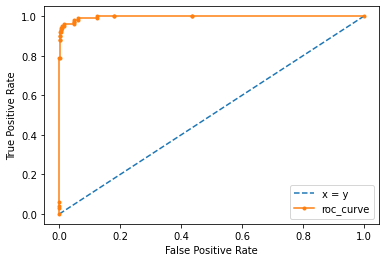



prauc_curve:


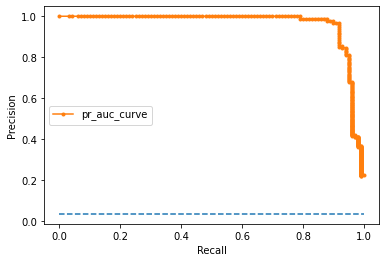

*******
Model name :  XGBClassifier(nthread=4)
Best Parameters {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 180}
AUC-score : [0.99966584593739]
Precision-Recall-auc:  [0.9924035166535963]
Balanced accuracy score [0.9911308476960956]
Recall : [0.99]
Precision : [0.8181818181818182]
F1_score [0.8959276018099549]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2843
           1       0.82      0.99      0.90       100

    accuracy                           0.99      2943
   macro avg       0.91      0.99      0.95      2943
weighted avg       0.99      0.99      0.99      2943

[[2821   22]
 [   1   99]]


roc_curve:


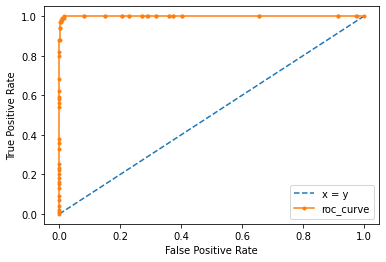



prauc_curve:


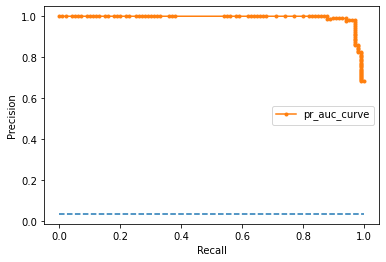

*******
Model name :  RandomForestClassifier(random_state=0)
Best Parameters {'bootstrap': False, 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}
AUC-score : [0.9995145972564193]
Precision-Recall-auc:  [0.9907538314454037]
Balanced accuracy score [0.9830654238480478]
Recall : [0.97]
Precision : [0.8981481481481481]
F1_score [0.9326923076923077]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2843
           1       0.90      0.97      0.93       100

    accuracy                           1.00      2943
   macro avg       0.95      0.98      0.97      2943
weighted avg       1.00      1.00      1.00      2943

[[2832   11]
 [   3   97]]


roc_curve:


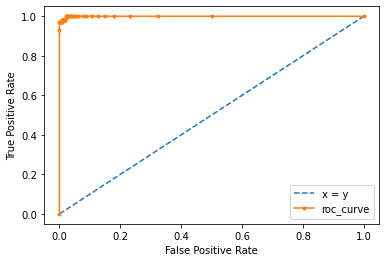



prauc_curve:


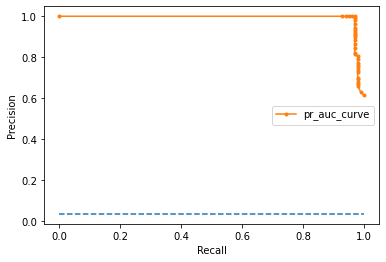

*******


In [64]:
for i in range(len(models)):
  print("Model name : ", models[i]["Model"])
  fit_score(grid_models[i], x_test_origin_featureselect ,y_test_origin)
  print("*******")

# ANN with oversampling

In [65]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu', input_dim=(x_train_smote.shape[1])))
    for i in range(hp.Int('n_layers', 1, 8)):
        model.add(layers.Dense(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), activation="relu"))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [66]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='LOG_DIR_SMOTE')

INFO:tensorflow:Reloading Oracle from existing project LOG_DIR_SMOTE\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from LOG_DIR_SMOTE\untitled_project\tuner0.json


In [67]:
tuner.search(x_train_smote,
            y_train_smote,
             epochs=7,
             batch_size=64,
             validation_data=(x_test_origin_featureselect, y_test_origin)
            )

INFO:tensorflow:Oracle triggered exit


In [68]:
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 384)               3456      
_________________________________________________________________
dense_1 (Dense)              (None, 160)               61600     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                5152      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3

In [69]:
tuner.get_best_hyperparameters()[0].values

{'units': 384,
 'n_layers': 5,
 'conv_0_units': 160,
 'learning_rate': 0.0001,
 'conv_1_units': 32,
 'conv_2_units': 32,
 'conv_3_units': 32,
 'conv_4_units': 32}

In [70]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

In [71]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test_origin_featureselect, y_test_origin)

2943/2943 [==============================] - ETA: 26s - loss: 0.0294 - accuracy: 1.000 - ETA: 0s - loss: 0.0459 - accuracy: 0.989 - ETA: 0s - loss: 0.0482 - accuracy: 0.98 - ETA: 0s - loss: 0.0462 - accuracy: 0.98 - ETA: 0s - loss: 0.0461 - accuracy: 0.98 - 1s 174us/sample - loss: 0.0466 - accuracy: 0.9895


In [72]:
print('the accuracy of the model is : ' ,  accuracy)

the accuracy of the model is :  0.98946655


In [73]:
predict_proba = best_model.predict_proba(x_test_origin_featureselect)

In [74]:
precision, recall, _ = precision_recall_curve(y_test_origin, predict_proba)
auc_score = auc(recall, precision)
print("The model prauc_score is {}.".format(auc_score))

The model prauc_score is 0.9739106784365578.


In [75]:
class_prediction = best_model.predict_classes(x_test_origin_featureselect)

In [76]:
print(classification_report(y_test_origin, class_prediction))
print(confusion_matrix(y_test_origin, class_prediction))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2843
           1       0.78      0.97      0.86       100

    accuracy                           0.99      2943
   macro avg       0.89      0.98      0.93      2943
weighted avg       0.99      0.99      0.99      2943

[[2815   28]
 [   3   97]]


## Implementing GANS

In [77]:
cgans = cGAN(8)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               4608      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)              

In [78]:
X_gans = X_train_origin.loc[:, randomForestFeatures]
X_gans

,V7,V3,V11,V4,V12,V17,V10,V14
0,0.239599,2.536347,-0.551600,1.378155,-0.617801,0.207971,0.090794,-0.311169
1,-0.078803,0.166480,1.612727,0.448154,1.065235,-0.114805,-0.166974,-0.143772
2,0.791461,1.773209,0.624501,0.379780,0.066084,1.109969,0.207643,-0.165946
3,0.237609,1.792993,-0.226487,-0.863291,0.178228,-0.684093,-0.054952,-0.287924
4,0.592941,1.548718,-0.822843,0.403034,0.538196,-0.237033,0.753074,-1.119670
...,...,...,...,...,...,...,...,...
284802,-4.918215,-9.834783,-1.593105,-2.066656,2.711941,1.991691,4.356170,4.626942
284803,0.024330,2.035030,-0.150189,-0.738589,0.915802,-0.025693,-0.975926,-0.675143
284804,-0.296827,-3.249640,0.411614,-0.557828,0.063119,0.313502,-0.484782,-0.510602
284805,-0.686180,0.702510,-1.933849,0.689799,-0.962886,0.509928,-0.399126,0.449624


In [79]:
y_train_gans = Y_train_origin.values.reshape(-1,1)
pos_index = np.where(y_train_gans==1)[0]
neg_index = np.where(y_train_gans==0)[0]
cgans.train(X_gans.values, y_train_gans, pos_index, neg_index, epochs=2000)

49 [D loss: 0.6441879272460938, acc.: 0.0] [G loss: [0.67209935, 0.78125]]
99 [D loss: 0.5340803265571594, acc.: 0.0] [G loss: [0.74292016, 0.4375]]
149 [D loss: -0.15433374047279358, acc.: 0.0] [G loss: [0.8282268, 0.25]]
199 [D loss: -3.7617080211639404, acc.: 0.0] [G loss: [1.0690165, 0.53125]]
249 [D loss: -30.17242431640625, acc.: 0.0] [G loss: [1.2656041, 0.375]]
299 [D loss: -27.494409561157227, acc.: 0.0] [G loss: [1.6475275, 0.53125]]
349 [D loss: -75.05335998535156, acc.: 0.0] [G loss: [1.3439896, 0.59375]]
399 [D loss: -167.4522705078125, acc.: 0.0] [G loss: [4.3456917, 0.5625]]
449 [D loss: -349.6986999511719, acc.: 0.0] [G loss: [4.216694, 0.65625]]
499 [D loss: -581.7980346679688, acc.: 0.0] [G loss: [8.088907, 0.59375]]
549 [D loss: -457.57806396484375, acc.: 0.0] [G loss: [13.64632, 0.28125]]
599 [D loss: -513.889404296875, acc.: 0.0] [G loss: [23.357021, 0.3125]]
649 [D loss: -1993.7330322265625, acc.: 0.0] [G loss: [28.414104, 0.5]]
699 [D loss: -2735.571533203125, ac

In [80]:
noise = np.random.normal(0, 1, (3508, 32))
sampled_labels = np.ones(3508).reshape(-1, 1)
gen_samples = cgans.generator.predict([noise, sampled_labels])
gen_samples.shape

(3508, 8)

In [81]:
data_fraud_gans= np.concatenate((data_class_fraud.loc[:, randomForestFeatures],gen_samples), axis=0) 

In [82]:
data_fraud_gans.shape

(4000, 8)

In [83]:
data_fraud_gans = np.concatenate((data_fraud_gans,np.ones((4000,1))),axis=1)
data_fraud_gans.shape

(4000, 9)

In [84]:
data_nonfraud_gans= data_train[data_train['Class']==0].sample(n=4000).loc[:, randomForestFeatures]
data_nonfraud_gans['Class']=0
data_nonfraud_gans

,V7,V3,V11,V4,V12,V17,V10,V14,Class
131356,-0.684784,1.362670,-0.187083,0.889259,0.732934,0.212574,-0.289122,-0.396167,0
37812,0.251587,-0.312330,1.927657,1.228753,0.905329,0.606949,-0.531107,-1.264444,0
110471,0.479206,-1.341276,0.184792,-0.746894,-0.425922,-0.162433,1.069423,-0.016324,0
185329,-1.184372,-0.034189,-0.732353,-1.890842,0.619753,-0.361390,-1.339080,-0.187159,0
71873,1.555357,-0.305253,0.686782,1.019381,-1.077168,2.647026,-1.769695,-3.614381,0
...,...,...,...,...,...,...,...,...,...
49687,-0.286290,0.537888,0.016831,-0.464661,0.586813,-0.019311,0.613558,-0.113597,0
53928,1.026557,0.738642,-0.709838,-0.478710,-0.619915,-0.534234,1.460643,-1.200488,0
75419,-0.029079,3.083696,-1.467732,1.187891,-0.740898,1.099905,-0.695499,-0.929346,0
32457,0.054521,2.078003,1.043887,4.174624,0.154455,0.535840,1.394601,0.155369,0


In [85]:
data_gans= np.concatenate((data_fraud_gans,data_nonfraud_gans), axis=0)
data_gans.shape
type(data_gans)
np.random.shuffle(data_gans)
data_gans.shape

(8000, 9)

In [86]:
Y_gans=data_gans[:, -1]
X_gans=data_gans[:,:-1]
X_gans.shape

(8000, 8)

In [87]:
grid_models =gridSearch(X_gans,Y_gans, models)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.4s finished


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  3.9min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  7.5min finished


Model name :  LogisticRegression(random_state=0)
Best Parameters {'C': 0.001, 'penalty': 'l2'}
AUC-score : [0.9784734435455504]
Precision-Recall-auc:  [0.9422914457200231]
Balanced accuracy score [0.9555029897995075]
Recall : [0.93]
Precision : [0.6326530612244898]
F1_score [0.7530364372469636]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2843
           1       0.63      0.93      0.75       100

    accuracy                           0.98      2943
   macro avg       0.82      0.96      0.87      2943
weighted avg       0.99      0.98      0.98      2943

[[2789   54]
 [   7   93]]


roc_curve:


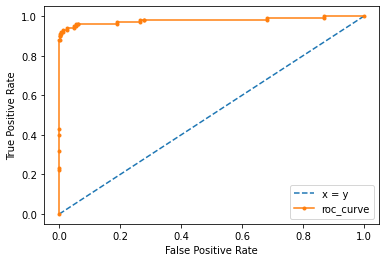



prauc_curve:


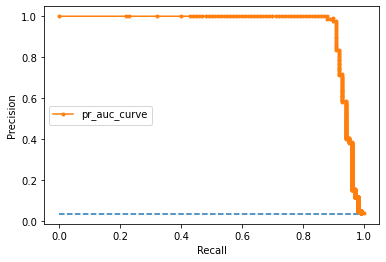

*********
Model name :  XGBClassifier(nthread=4)
Best Parameters {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 60}
AUC-score : [0.9993950052761168]
Precision-Recall-auc:  [0.9888203430607261]
Balanced accuracy score [0.9878895532887795]
Recall : [0.98]
Precision : [0.8909090909090909]
F1_score [0.9333333333333333]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2843
           1       0.89      0.98      0.93       100

    accuracy                           1.00      2943
   macro avg       0.95      0.99      0.97      2943
weighted avg       1.00      1.00      1.00      2943

[[2831   12]
 [   2   98]]


roc_curve:


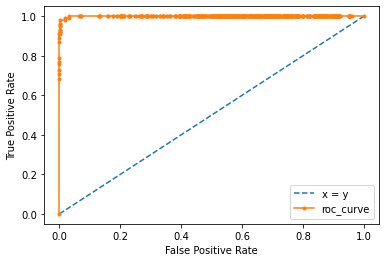



prauc_curve:


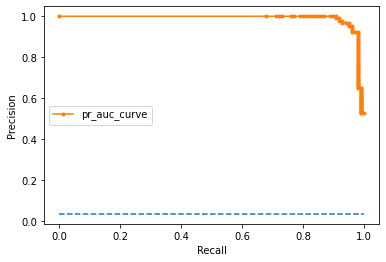

*********
Model name :  RandomForestClassifier(random_state=0)
Best Parameters {'bootstrap': False, 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
AUC-score : [1.0]
Precision-Recall-auc:  [1.0]
Balanced accuracy score [0.998593035525853]
Recall : [1.0]
Precision : [0.9259259259259259]
F1_score [0.9615384615384615]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2843
           1       0.93      1.00      0.96       100

    accuracy                           1.00      2943
   macro avg       0.96      1.00      0.98      2943
weighted avg       1.00      1.00      1.00      2943

[[2835    8]
 [   0  100]]


roc_curve:


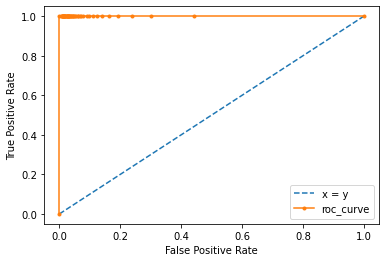



prauc_curve:


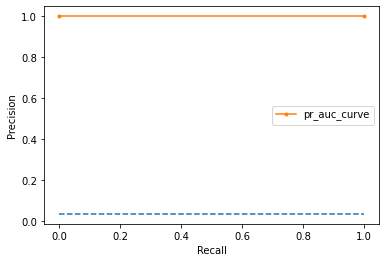

*********


In [88]:
for i in range(len(models)):
  print("Model name : ", models[i]["Model"])
  fit_score(grid_models[i], x_test_origin_featureselect.values,y_test_origin)
  print("*********")

## ANN with GANS

In [89]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu', input_dim=(X_gans.shape[1])))
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(layers.Dense(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), activation="relu"))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [90]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='LOG_DIR_GANS')

INFO:tensorflow:Reloading Oracle from existing project LOG_DIR_GANS\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from LOG_DIR_GANS\untitled_project\tuner0.json


In [91]:
tuner.search(X_gans,
            Y_gans,
             epochs=7,
             batch_size=64,
             validation_data=(x_test_origin_featureselect, y_test_origin)
            )

INFO:tensorflow:Oracle triggered exit


In [92]:
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 480)               4320      
_________________________________________________________________
dense_1 (Dense)              (None, 96)                46176     
_________________________________________________________________
dense_2 (Dense)              (None, 160)               15520     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                10304     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 224)               14560     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2

In [93]:
tuner.get_best_hyperparameters()[0].values

{'units': 480,
 'n_layers': 5,
 'conv_0_units': 96,
 'learning_rate': 0.01,
 'conv_1_units': 160,
 'conv_2_units': 64,
 'conv_3_units': 64,
 'conv_4_units': 224,
 'conv_5_units': 224}

In [94]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

In [95]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test_origin_featureselect, y_test_origin)

2943/2943 [==============================] - ETA: 25s - loss: 0.0039 - accuracy: 1.000 - ETA: 0s - loss: 0.0194 - accuracy: 0.997 - ETA: 0s - loss: 0.0244 - accuracy: 0.99 - ETA: 0s - loss: 0.0212 - accuracy: 0.99 - ETA: 0s - loss: 0.0194 - accuracy: 0.99 - 0s 169us/sample - loss: 0.0196 - accuracy: 0.9966


In [96]:
print('the accuracy of the model is : ' ,  accuracy)

the accuracy of the model is :  0.9966021


In [97]:
predict_proba_gans = best_model.predict_proba(x_test_origin_featureselect)
precision, recall, _ = precision_recall_curve(y_test_origin, predict_proba_gans)
auc_score = auc(recall, precision)
print("The model prauc_score is {}.".format(auc_score))

The model prauc_score is 0.967018776164681.


In [98]:
class_prediction_gans = best_model.predict_classes(x_test_origin_featureselect)
print( classification_report(y_test_origin, class_prediction_gans))
print(confusion_matrix(y_test_origin, class_prediction_gans))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2843
           1       0.98      0.92      0.95       100

    accuracy                           1.00      2943
   macro avg       0.99      0.96      0.97      2943
weighted avg       1.00      1.00      1.00      2943

[[2841    2]
 [   8   92]]


## Make pipeline

if we run all : the data is all ready scaled so the pipeline will give an error, therefor we have to reexecute the data 

In [99]:
def pipeline(data):
    rob_scaler = RobustScaler()
    scaled_amount = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
    scaled_time = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))
    data.insert(0, 'scaled_amount', scaled_amount)
    data.insert(1, 'scaled_time', scaled_time)
    data.drop(['Time','Amount'], axis=1, inplace=True)
    
    randomForestFeatures = randomForestSelector(X_RF, Y_RF, 8)
    
    cgans = cGAN(8)
    X_gans = data.loc[:, randomForestFeatures]
    y_train_gans = data['Class'].values.reshape(-1,1)
    pos_index = np.where(y_train_gans==1)[0]
    neg_index = np.where(y_train_gans==0)[0]
    cgans.train(X_gans.values, y_train_gans, pos_index, neg_index, epochs=2000)
    noise = np.random.normal(0, 1, (3508, 32))
    sampled_labels = np.ones(3508).reshape(-1, 1)
    gen_samples = cgans.generator.predict([noise, sampled_labels])
    data_class_fraud=data.loc[data['Class'] == 1]
    data_fraud_gans= np.concatenate((data_class_fraud.loc[:, randomForestFeatures],gen_samples), axis=0) 
    data_fraud_gans = np.concatenate((data_fraud_gans,np.ones((4000,1))),axis=1)
    data_nonfraud_gans= data[data['Class']==0].sample(n=4000).loc[:, randomForestFeatures]
    data_nonfraud_gans['Class']=0
    data_gans= np.concatenate((data_fraud_gans,data_nonfraud_gans), axis=0)
    np.random.shuffle(data_gans)
    Y_gans=data_gans[:, -1]
    X_gans=data_gans[:,:-1]
    clf = RandomForestClassifier(random_state=0, bootstrap=False, max_depth=20, min_samples_split=2, n_estimators=100)
    clf.fit(X_gans,Y_gans)
    return clf

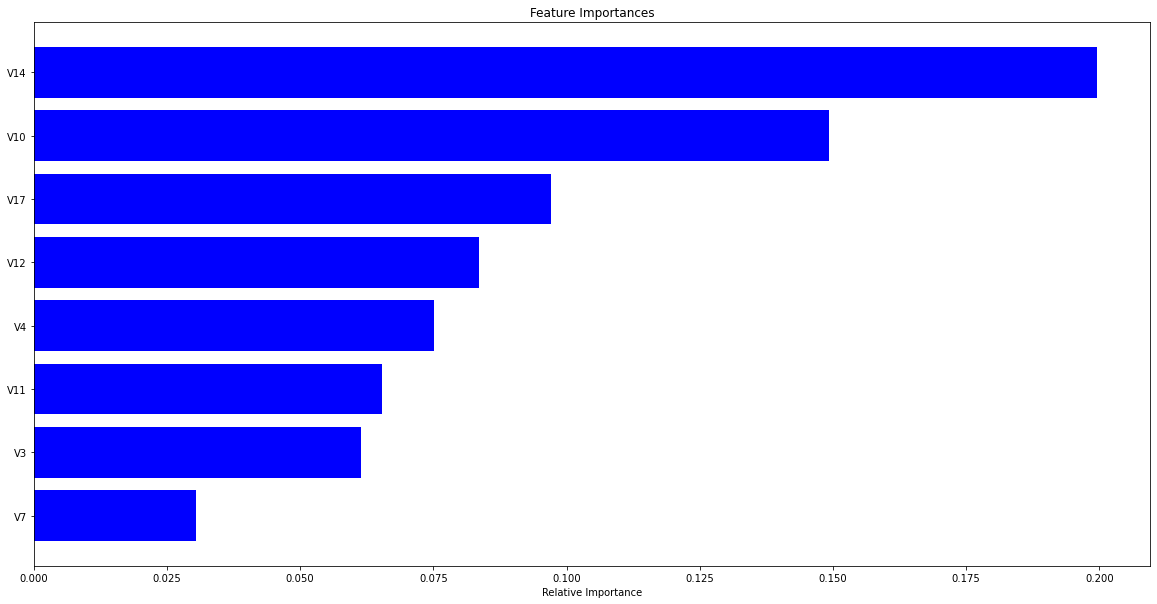

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               4608      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)              

In [100]:
pipe = pipeline(data)

In [101]:
def fit_score2(model,X_test,y_test):
    y_pred = model.predict(X_test)
    probs=model.predict_proba(X_test)
    probs_ov=probs[:,1]

    print('AUC-score :',  [roc_auc_score(y_test, probs_ov)],)
    precision, recall,_ = precision_recall_curve(y_test, probs_ov)
    print("Precision-Recall-auc: ", [auc(recall, precision)])
    print('Balanced accuracy score', [balanced_accuracy_score(y_test,y_pred)])   
    print('Recall :' ,  [recall_score(y_test, y_pred)])
    print( 'Precision :' , [precision_score(y_test, y_pred)],)
    print('F1_score' , [fbeta_score(y_test,y_pred, beta=1.0)])  
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    print("\n\nroc_curve:")
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = roc_auc_score(y_test, ns_probs)

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, probs_ov)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='x = y')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='roc_curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    print("\n\nprauc_curve:")
    x_y = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [x_y, x_y], linestyle='--')
    plt.plot(recall, precision, marker='.', label='pr_auc_curve')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

AUC-score : [1.0]
Precision-Recall-auc:  [1.0]
Balanced accuracy score [0.998593035525853]
Recall : [1.0]
Precision : [0.9259259259259259]
F1_score [0.9615384615384615]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2843
           1       0.93      1.00      0.96       100

    accuracy                           1.00      2943
   macro avg       0.96      1.00      0.98      2943
weighted avg       1.00      1.00      1.00      2943

[[2835    8]
 [   0  100]]


roc_curve:


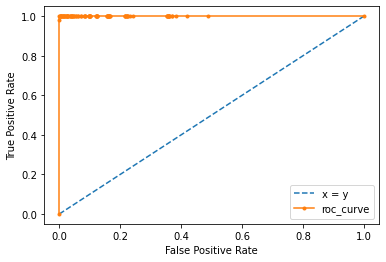



prauc_curve:


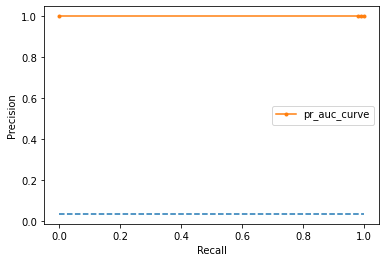

In [102]:
fit_score2(pipe, x_test_origin_featureselect,y_test_origin)